In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install imblearn

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [11]:
def plot_target_distribution(target):
    """Plot for the distribution of the target variable"""
    target_distribution = target.value_counts()
    print('Class Distribution:\n', target_distribution)
    target_distribution.plot(kind='bar', title='Target Class Distribution')
    plt.show()

def resample_data(X, y, random_state=20):
    """Addressing the class imbalance using SMOTE after resampling the dataset"""
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original class distribution: {Counter(y)}")
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    return X_resampled, y_resampled

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate the model with performance metrics."""
    # Calculating the cross-validation score
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    print(f"{model_name} Cross-validation score: {cv_score:.2%}")

    # Training the model
    model.fit(X_train, y_train)

    # Evaluating it on the test set
    test_score = model.score(X_test, y_test)
    print(f"{model_name} Test set score: {test_score:.2%}")

    # Here are the predictions
    y_pred = model.predict(X_test)

    # Here is the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix)
    plot_confusion_matrix(conf_matrix, model_name)

    # the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, zero_division=1)
    auc = roc_auc_score(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Precision: {precision:.2f}")
    print(f"{model_name} Recall: {recall:.2f}")
    print(f"{model_name} F1-Score: {f1score:.2f}")
    print(f"{model_name} AUC: {auc:.2f}")

    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1score,
        "roc_auc": auc
    }

def plot_confusion_matrix(conf_matrix, model_name):
    """Plotting a heatmap for a confusion matrix"""
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [12]:
# data = pd.read_csv('/content/drive/MyDrive/ECS_271/cleaned_data_2.csv')
data = pd.read_csv('/content/drive/MyDrive/Patient-Readmit-Prediction-main/cleaned_data_2.csv')

In [16]:
feature_set= ['race_1','race_2','race_3','race_4','gender_1','age','admission_type_id_3',
       'admission_type_id_4','admission_type_id_5','discharge_disposition_id_2',
        'discharge_disposition_id_7','discharge_disposition_id_10','discharge_disposition_id_18','discharge_disposition_id_19',
        'discharge_disposition_id_20','discharge_disposition_id_27','discharge_disposition_id_28','admission_source_id_4', 'admission_source_id_8',
        'admission_source_id_9','admission_source_id_11','num_lab_procedures','number_diagnoses', 'max_glu_serum_1.0', 'A1Cresult_1',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
        'total_medications', 'primary_diag_1','primary_diag_2','primary_diag_3','primary_diag_4','primary_diag_5','primary_diag_6','primary_diag_7','primary_diag_8',
        'number_emergency_log','patient_activity_log', 'time_in_hospital_log', 'medication_variaton_log',
       'num_procedures_log', 'number_outpatient_log', 'num_medications_log',
       'number_inpatient_log']
features = data[feature_set]
target = data['readmitted']

Class Distribution:
 readmitted
0    79512
1     9607
Name: count, dtype: int64


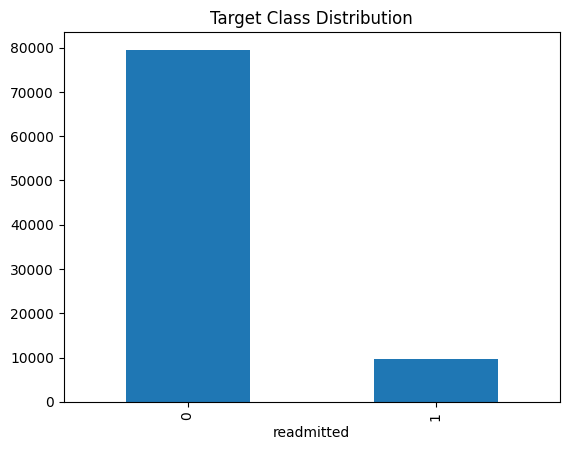

Original class distribution: Counter({0: 71569, 1: 8638})
Resampled class distribution: Counter({0: 71569, 1: 71569})


In [17]:

# The distribution of the target variable
plot_target_distribution(target)

# Splitting the dataset into a train and a test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0)

# Addressing the class imbalance after resampling the dataset
X_resampled, y_resampled = resample_data(X_train, y_train)

# Saving it to a CSV file
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=features.columns), pd.DataFrame(y_resampled, columns=['readmitted'])], axis=1)
resampled_data.to_csv('./smote_data.csv', index=False)

# Further splitting the resampled data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=0
)

In [18]:

models = {
    "Logistic Regression": LogisticRegression(fit_intercept=True, penalty='l2', C=1.0, solver='liblinear', random_state=0),  # Adjusted C for regularization
    "Decision Tree": DecisionTreeClassifier(max_depth=20, criterion="gini", min_samples_split=5, min_samples_leaf=2, random_state=0),  # Smaller depth and leaf constraints
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, criterion='gini', random_state=0),  # Increased estimators
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=4, min_samples_split=5, random_state=0),  # Adjusted learning rate and depth
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='auto', p=2),  # Weighted voting and optimized neighbors
    "Naive Bayes": GaussianNB(var_smoothing=1e-9),  # Default value is usually sufficient, but you can fine-tune `var_smoothing`
    "LDA": LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),  # Added shrinkage for better regularization
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=0)  # Increased estimators and added leaf constraints
}


--- Evaluating Logistic Regression ---
Logistic Regression Cross-validation score: 76.12%
Logistic Regression Test set score: 76.29%
Logistic Regression Confusion Matrix:
 [[11577  2733]
 [ 4056 10262]]


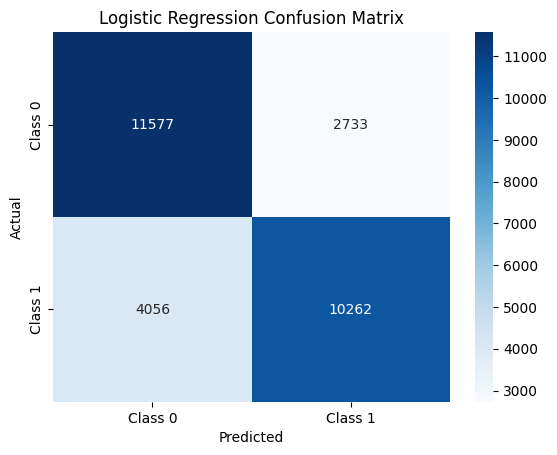

Logistic Regression Accuracy: 0.76
Logistic Regression Precision: 0.79
Logistic Regression Recall: 0.72
Logistic Regression F1-Score: 0.75
Logistic Regression AUC: 0.76

--- Evaluating Decision Tree ---
Decision Tree Cross-validation score: 88.38%
Decision Tree Test set score: 88.73%
Decision Tree Confusion Matrix:
 [[13268  1042]
 [ 2183 12135]]


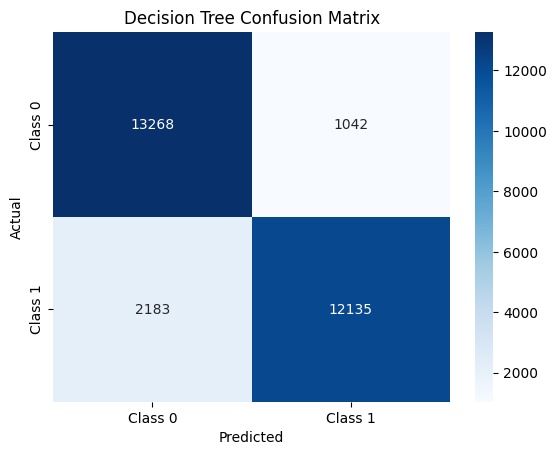

Decision Tree Accuracy: 0.89
Decision Tree Precision: 0.92
Decision Tree Recall: 0.85
Decision Tree F1-Score: 0.88
Decision Tree AUC: 0.89

--- Evaluating Random Forest ---
Random Forest Cross-validation score: 91.59%
Random Forest Test set score: 91.77%
Random Forest Confusion Matrix:
 [[13730   580]
 [ 1777 12541]]


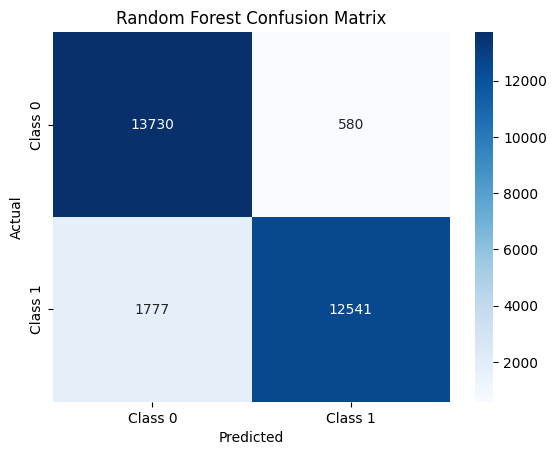

Random Forest Accuracy: 0.92
Random Forest Precision: 0.96
Random Forest Recall: 0.88
Random Forest F1-Score: 0.91
Random Forest AUC: 0.92

--- Evaluating Gradient Boosting ---
Gradient Boosting Cross-validation score: 91.24%
Gradient Boosting Test set score: 91.39%
Gradient Boosting Confusion Matrix:
 [[14272    38]
 [ 2426 11892]]


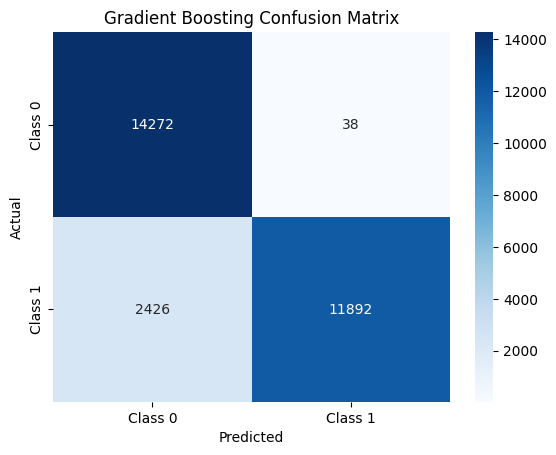

Gradient Boosting Accuracy: 0.91
Gradient Boosting Precision: 1.00
Gradient Boosting Recall: 0.83
Gradient Boosting F1-Score: 0.91
Gradient Boosting AUC: 0.91

--- Evaluating KNN ---
KNN Cross-validation score: 83.12%
KNN Test set score: 83.70%
KNN Confusion Matrix:
 [[ 9777  4533]
 [  133 14185]]


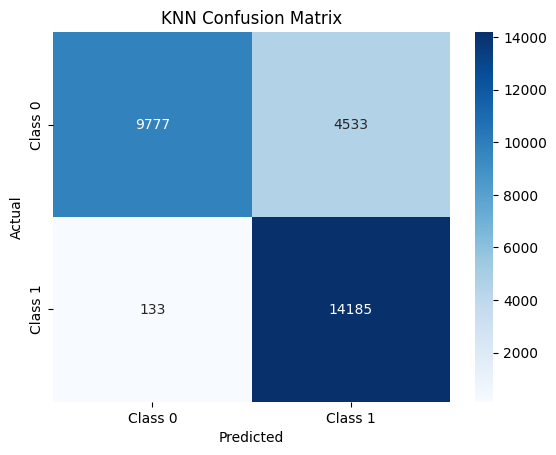

KNN Accuracy: 0.84
KNN Precision: 0.76
KNN Recall: 0.99
KNN F1-Score: 0.86
KNN AUC: 0.84

--- Evaluating Naive Bayes ---
Naive Bayes Cross-validation score: 51.58%
Naive Bayes Test set score: 51.62%
Naive Bayes Confusion Matrix:
 [[  617 13693]
 [  156 14162]]


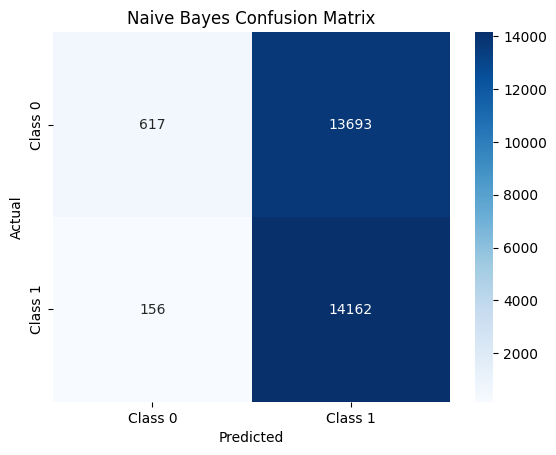

Naive Bayes Accuracy: 0.52
Naive Bayes Precision: 0.51
Naive Bayes Recall: 0.99
Naive Bayes F1-Score: 0.67
Naive Bayes AUC: 0.52

--- Evaluating LDA ---
LDA Cross-validation score: 73.74%
LDA Test set score: 73.98%
LDA Confusion Matrix:
 [[10638  3672]
 [ 3778 10540]]


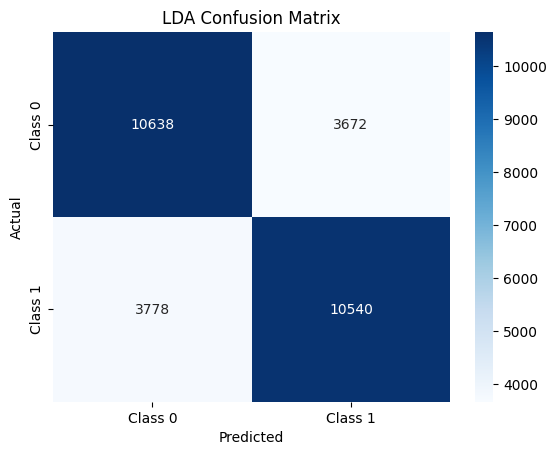

LDA Accuracy: 0.74
LDA Precision: 0.74
LDA Recall: 0.74
LDA F1-Score: 0.74
LDA AUC: 0.74

--- Evaluating Extra Trees ---
Extra Trees Cross-validation score: 83.48%
Extra Trees Test set score: 83.79%
Extra Trees Confusion Matrix:
 [[11893  2417]
 [ 2225 12093]]


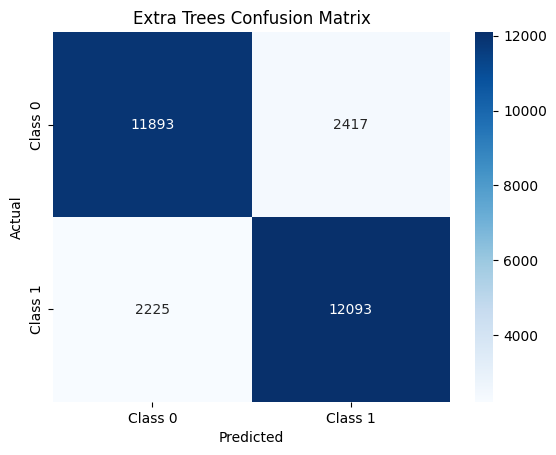

Extra Trees Accuracy: 0.84
Extra Trees Precision: 0.83
Extra Trees Recall: 0.84
Extra Trees F1-Score: 0.84
Extra Trees AUC: 0.84

Model Performance Summary:
                 model  accuracy  precision    recall  f1_score   roc_auc
0  Logistic Regression  0.762855   0.789688  0.716720  0.751437  0.762867
1        Decision Tree  0.887348   0.920923  0.847535  0.882706  0.887359
2        Random Forest  0.917668   0.955796  0.875890  0.914100  0.917680
3    Gradient Boosting  0.913930   0.996815  0.830563  0.906126  0.913954
4                  KNN  0.837013   0.757827  0.990711  0.858760  0.836970
5          Naive Bayes  0.516243   0.508419  0.989105  0.671615  0.516111
6                  LDA  0.739765   0.741627  0.736136  0.738871  0.739766
7          Extra Trees  0.837851   0.833425  0.844601  0.838976  0.837849


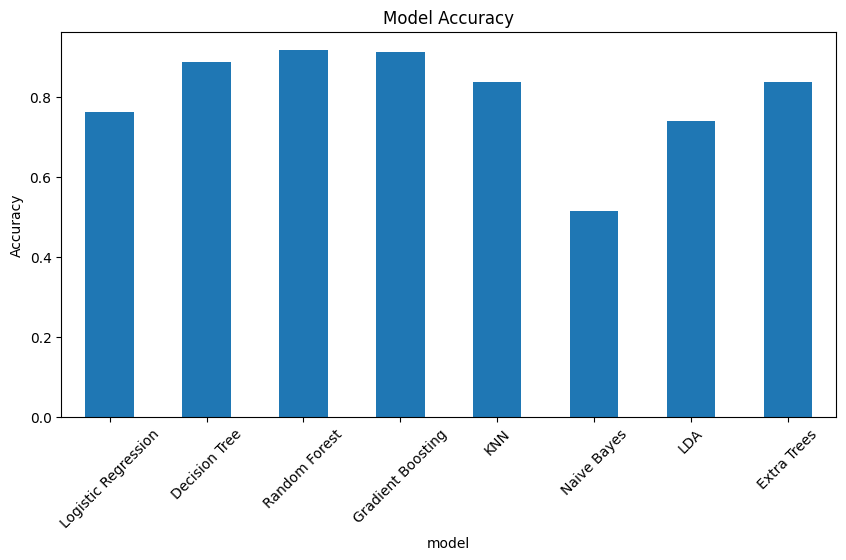

In [19]:
model_metrics = []
for model_name, model in models.items():
    print(f"\n--- Evaluating {model_name} ---")
    metrics = evaluate_model(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, model_name)
    model_metrics.append(metrics)
metrics_df = pd.DataFrame(model_metrics)
print("\nModel Performance Summary:")
print(metrics_df)

# Here is accuracy's bar graph
metrics_df.plot(x='model', y='accuracy', kind='bar', legend=False, title="Model Accuracy", figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

<ipython-input-20-493e4e1b6aff>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='viridis')


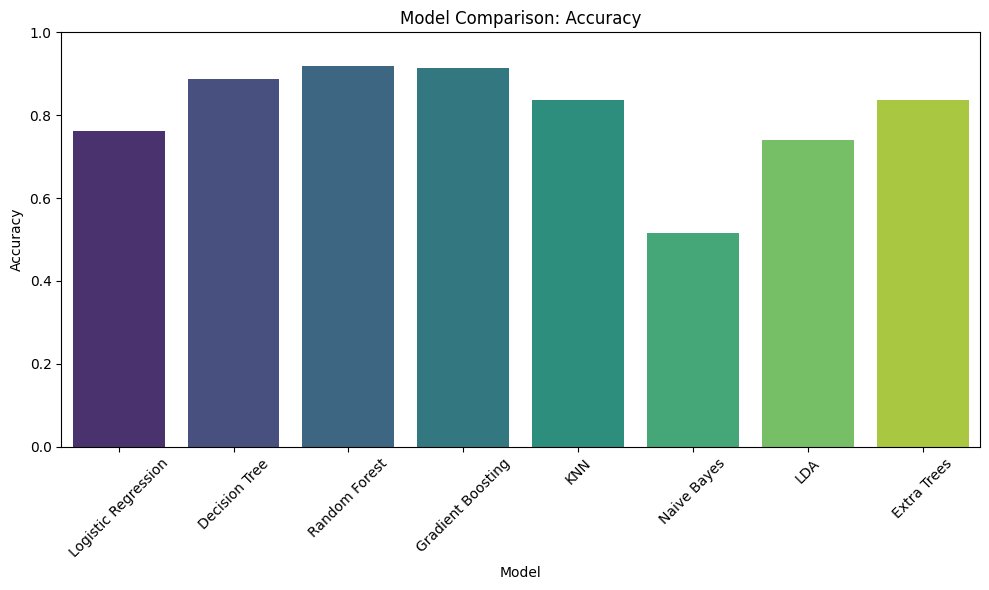

<ipython-input-20-493e4e1b6aff>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='viridis')


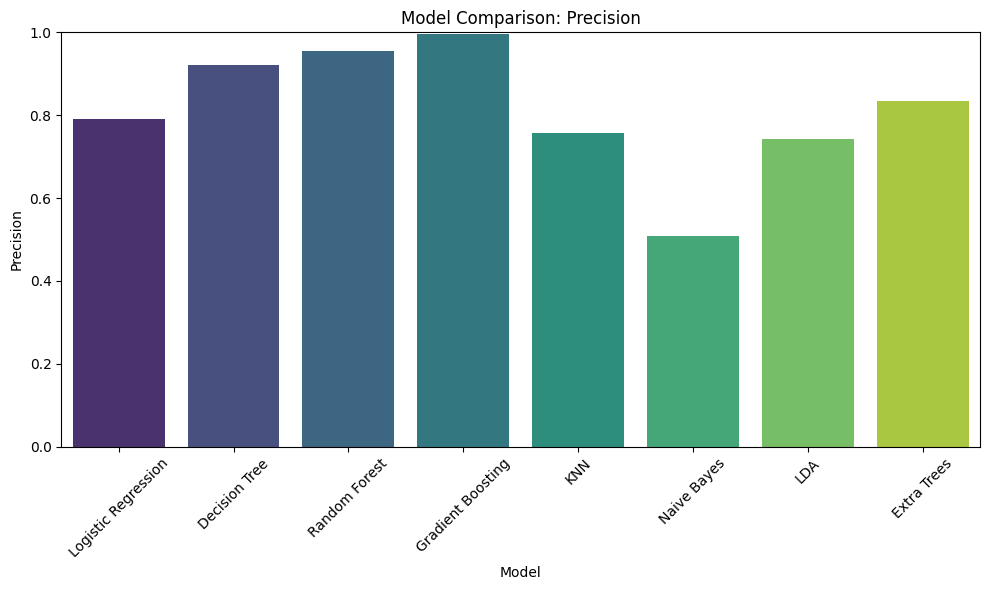

<ipython-input-20-493e4e1b6aff>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='viridis')


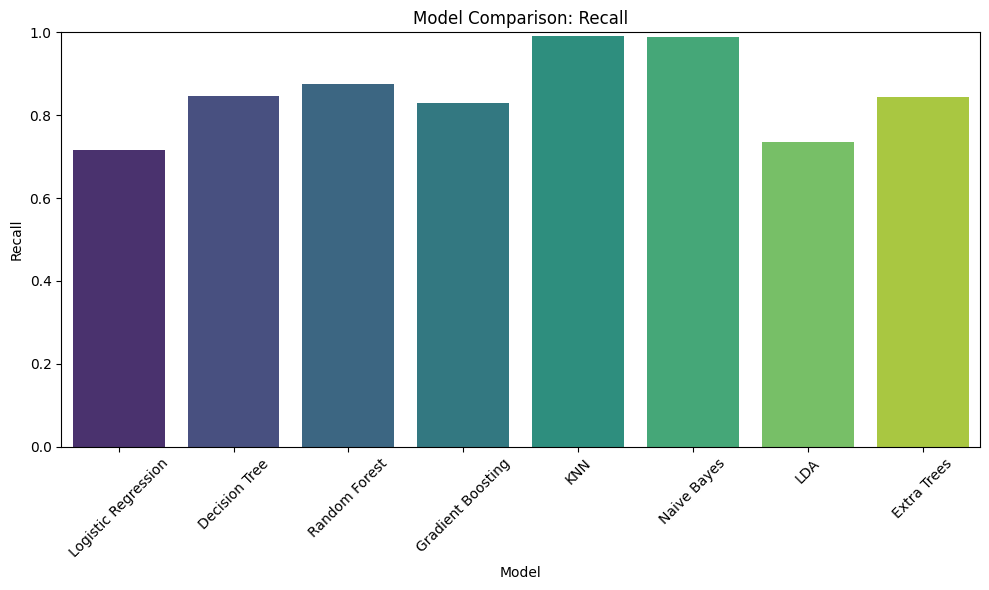

In [20]:
# Comparative Analysis for Metrics
def plot_comparative_metrics(metrics_df, metrics=['accuracy', 'precision', 'recall']):
    """
    Plot bar charts to compare accuracy, precision, and recall across models.
    """
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='model', y=metric, data=metrics_df, palette='viridis')
        plt.title(f'Model Comparison: {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        # Assuming that all metrics fall between 0 and 1
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

# Plot metrics
plot_comparative_metrics(metrics_df, metrics=['accuracy', 'precision', 'recall'])


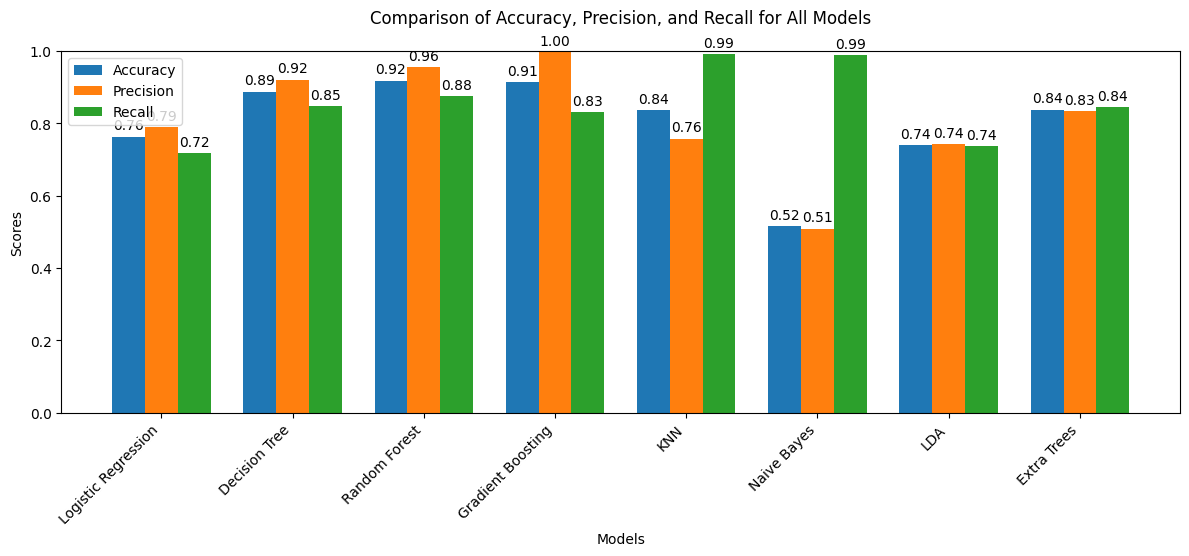

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_metrics(metrics_df):
    """The below group plot for the bar chart is to compare the accuracy, precision and recall among the models."""
    metrics = ['accuracy', 'precision', 'recall']
    x = np.arange(len(metrics_df['model']))
    # Setting the width of the bars
    width = 0.25

    # Subplots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Bars for each metric
    accuracy_bars = ax.bar(x - width, metrics_df['accuracy'], width, label='Accuracy')
    precision_bars = ax.bar(x, metrics_df['precision'], width, label='Precision')
    recall_bars = ax.bar(x + width, metrics_df['recall'], width, label='Recall')

    # Adding labels, title and axes ticks
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Accuracy, Precision, and Recall for All Models', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df['model'], rotation=45, ha='right')
    # Assuming that all metrics fall between 0 and 1
    ax.set_ylim(0, 1)
    ax.legend()

    # This will display values above the bars
    def add_bar_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    add_bar_labels(accuracy_bars)
    add_bar_labels(precision_bars)
    add_bar_labels(recall_bars)

    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()

# Call the function to plot
plot_combined_metrics(metrics_df)
